# Defensive Asset Allocation with momentum
## Use Index of representative asset classes
#### Market Index ETF, sector etf, bond etf are included
#### Result is driven from 2010 to 2021 market data

In [73]:
import warnings
warnings.filterwarnings('ignore')

In [74]:
import pandas as pd
import numpy as np

from utils.yahoo_stock_data import yahoo_data
from utils.regular_rebalancing import momentum_rebalance_strategy

import quantstats

### Load Data of each asset classes
##### Use representative ETF to model strategy
##### Data should be in yld format [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]

In [75]:
asset_class_ticker =[
    "IVV",  # iShares Core S&P 500 ETF                              2000-05-15
    "QQQ",  # Invesco QQQ trust Nasdaq 100                          1999-03-10
    "VEA",  # Vanguard FTSE Developed Markets ETF                   2007-07-02
    # "VWO",  # Vanguard FTSE Emerging Markets ETF                    2005-03-04
    "TLT",  # iShares 20+ Year Treasury Bond ETF                    2002-07-22
    "RWR",  # SPDR® Dow Jones® REIT ETF                             2001-04-23
    "GSG",  # iShares S&P GSCI Commodity-Indexed Trust              2006-07-10

    # Defensive Assets
    "SHY",  # iShares 1-3 Year Treasury Bond ETF                    2002-07-22
    "IEI",  # iShares 3-7 Year Treasury Bond ETF                    2007-01-05

    # Canaria Assets
    "VWO",  # Vanguard FTSE Emerging Markets ETF                    2005-03-04
    "BND",  # iShares 7-10 Year Treasury Bond ETF                   2002-07-22
    ]

bm_class_ticker =[
    "VTI", # Vanguard Total Stock Market ETF                        2001-05-24
    "TLT", # iShares 20+ Year Treasury Bond ETF                     2002-07-22
    "IEI", # iShares 3-7 Year Treasury Bond ETF                     2007-01-05
    "GLD", # SPDR Gold Trust                                        2004-11-18
    "GSG"  # iShares S&P GSCI Commodity Indexed Trust               2006-07-10
    ]

In [76]:
# for monthly rebalance strategy
data_setting = {
    'start' : '2007-01-01',
    'end' : '2022-03-01',
    'ticker_list': asset_class_ticker,
    'rebal_period' : '1M',
}

data = yahoo_data(**data_setting)
yield_df = data.yahoo_stock_data_loading()

# to draw benchmark
data_setting = {
    'start' : '2007-01-01',
    'end' : '2022-03-01',
    'ticker_list': bm_class_ticker,
    'rebal_period' : '1M',
}

data = yahoo_data(**data_setting)
benchmark_yield_df = data.yahoo_stock_data_loading()

In [77]:
def all_weather_strategy(yld_df):
    weights = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
    weights.loc[:,'VTI'] = 0.300
    weights.loc[:,'TLT'] = 0.400
    weights.loc[:,'IEI'] = 0.150
    weights.loc[:,'GLD'] = 0.075
    weights.loc[:,'GSG'] = 0.075
    return weights

In [93]:
def get_momentum(yld_df):
    """
    calculate momentum of sectors. using 12 month, 6 month, 3 month market price of asset
    input
    yiled_df : dataframe with weekly yield of asset classes

    returns : momentum in pandas dataframe format. momentum of each asset classes for give date
    """
    momentum = pd.DataFrame(columns = yld_df.columns, index = yld_df.index)

    for asset in  yld_df.columns:
        i = 0
        for date in yld_df.index:
            # data set consists of weekly data
            # 52 weeks per year = 12 month per year
            if i > 12 :
                # first 12 month data (52 data points) cannot be used since 12 month lagged returns is required
                current = yld_df[asset].iloc[i]
                before_1m = yld_df[asset].iloc[i-1]
                before_3m = yld_df[asset].iloc[i-3]
                before_6m = yld_df[asset].iloc[i-6]
                before_12m = yld_df[asset].iloc[i-12]

                momentum.loc[date, asset] = 12*(current/before_1m - 1) + 4*(current/before_3m - 1) \
                                            + 2*(current/before_6m - 1) + 1*(current/before_12m - 1)
            else:
                momentum.loc[date, asset] = 0
            i = i + 1

    # abnormal data processing
    momentum = momentum.replace([np.inf], 1000)
    momentum = momentum.replace([-np.inf], -1000)
    momentum = momentum.replace([np.nan], 0)
    return momentum

def select_sector(yld_df):
    """
    select top scored two offensive sectors if condition satisfied(canaria not dead).
    If failed to save canaria, escape to Defensive strategy.

    Criteria: if any of canaria asset classes show negative momentum score, escape to canaria assets.

    returns: selected_tickers in list format. list with top 5 momentum in given period`
    """
    momentum_df = get_momentum(yld_df)

    selected_momentum = pd.DataFrame(
        columns=['momentum_1','momentum_2'],
        index=momentum_df.index
    )
    selected_ticker = pd.DataFrame(
        columns=['momentum_1','momentum_2'],
        index=momentum_df.index
    )

    selectable_asset = [
    "IVV",  # iShares Core S&P 500 ETF                              2000-05-15
    "QQQ",  # Invesco QQQ trust Nasdaq 100                          1999-03-10
    "VEA",  # Vanguard FTSE Developed Markets ETF                   2007-07-02
    "VWO",  # Vanguard FTSE Emerging Markets ETF                    2005-03-04
    "TLT",  # iShares 20+ Year Treasury Bond ETF                    2002-07-22
    "RWR",  # SPDR® Dow Jones® REIT ETF                             2001-04-23
    "GSG",  # iShares S&P GSCI Commodity-Indexed Trust              2006-07-10
    ]
    print("emerging market signal : Total ",momentum_df.count()[0])
    print("postive signal : ", momentum_df[momentum_df['VWO'] >= 0]['VWO'].count())
    print("negative signal : ", momentum_df[momentum_df['VWO'] < 0]['VWO'].count())


    print("bond market signal : Total ",momentum_df.count()[0])
    print("postive signal : ", momentum_df[momentum_df['BND'] >= 0]['BND'].count())
    print("negative signal : ", momentum_df[momentum_df['BND'] < 0]['BND'].count())


    for date in momentum_df.index:
        emerging_momentum = momentum_df.loc[date,'VWO']
        bnd_momentum = momentum_df.loc[date,'BND']

        short_treasury_momentum = momentum_df.loc[date,'SHY']
        mid_treasury_momentum = momentum_df.loc[date,'IEI']

        sorted_momentum = momentum_df[selectable_asset].loc[date].sort_values(ascending=False)

        if emerging_momentum >= 0 and bnd_momentum >= 0:
            selected_momentum.loc[date,'momentum_1'] = sorted_momentum[0]
            selected_ticker.loc[date,'momentum_1'] = sorted_momentum.index[0]

            selected_momentum.loc[date,'momentum_2'] = sorted_momentum[1]
            selected_ticker.loc[date,'momentum_2'] = sorted_momentum.index[1]

        else:
            selected_momentum.loc[date,'momentum_1'] = short_treasury_momentum
            selected_ticker.loc[date,'momentum_1'] = 'SHY'

            selected_momentum.loc[date,'momentum_2'] = mid_treasury_momentum
            selected_ticker.loc[date,'momentum_2'] = 'IEI'

    return selected_ticker


def daa_momentum(yld_df):
    """
    returns : market portfolio in pandas dataframe format.
    """
    mom_ticker_df = select_sector(yld_df)
    mp_table = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
    for date in mom_ticker_df.index:
        selected = mom_ticker_df.loc[date].tolist()
        for sel in selected:
            mp_table.loc[date, sel] = 1/2
    mp_table = mp_table.fillna(0)

    return mp_table

def trim_data(yld_df, mp_table, benchmark_yield_df):
   """
    since momentum strategy uses 12 month lagged momentum, first 12 month data cannot be used
    return : yld_df, mp_table, bm_yld in dataframe format
    """
    yld_df = yld_df.iloc[12 + 1:]
    mp_table = mp_table.iloc[12 + 1:]
    benchmark_yield_df = benchmark_yield_df.iloc[12 + 1:]
    return yld_df, mp_table, benchmark_yield_df

In [94]:
mp_table_result = daa_momentum(yield_df)
yield_df, mp_table_result, benchmark_yield_df = trim_data(yield_df, mp_table_result, benchmark_yield_df)
mp_table_result

emerging market signal : Total  163
postive signal :  46
negative signal :  117
bond market signal : Total  163
postive signal :  46
negative signal :  117


,IVV,QQQ,VEA,TLT,RWR,GSG,SHY,IEI,VWO,BND
Date,,,,,,,,,,
2009-10-31,0.0,0.0,0.0,0,0.0,0.0,0.5,0.5,0.0,0
2009-11-30,0.0,0.0,0.0,0,0.0,0.0,0.5,0.5,0.0,0
2009-12-31,0.0,0.0,0.0,0,0.0,0.0,0.5,0.5,0.0,0
2010-01-31,0.0,0.0,0.0,0,0.0,0.0,0.5,0.5,0.0,0
2010-02-28,0.0,0.0,0.0,0,0.0,0.0,0.5,0.5,0.0,0
...,...,...,...,...,...,...,...,...,...,...
2021-11-30,0.0,0.0,0.0,0,0.0,0.0,0.5,0.5,0.0,0
2021-12-31,0.0,0.0,0.0,0,0.0,0.0,0.5,0.5,0.0,0
2022-01-31,0.0,0.0,0.0,0,0.0,0.0,0.5,0.5,0.0,0


In [80]:
# How many times this strategy escaped from risky but opportunistic assets
print("frequency of portfolio")
mp_table_result.sum() * 2

frequency of portfolio


IVV      2.0
QQQ      2.0
VEA      2.0
TLT      1.0
RWR      2.0
GSG      3.0
SHY    155.0
IEI    155.0
VWO      4.0
BND      0.0
dtype: float64

In [81]:
rebal_strategy = momentum_rebalance_strategy(
    strategy=daa_momentum, yld_df=yield_df,
    bm_strategy=all_weather_strategy, bm_yld_df=benchmark_yield_df,
    lookback_period=0
)
rebal_strategy = rebal_strategy.iloc[12:]
rebal_strategy

emerging market signal : Total  163
postive signal :  46
negative signal :  117
bond market signal : Total  163
postive signal :  46
negative signal :  117


,strategy_return,benchmark_return,IVV,QQQ,VEA,TLT,RWR,GSG,SHY,IEI,VWO,BND,SUM
Date,,,,,,,,,,,,,
2009-09-30,-0.010335,-0.059164,0.5,0.5,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1.0
2009-10-31,0.038941,0.070401,0.0,0.0,0.0,0,0.0,0.0,0.5,0.5,0.0,0,1.0
2009-11-30,-0.001823,-0.008364,0.0,0.0,0.0,0,0.0,0.0,0.5,0.5,0.0,0,1.0
2009-12-31,0.011157,0.019015,0.0,0.0,0.0,0,0.0,0.0,0.5,0.5,0.0,0,1.0
2010-01-31,-0.01481,0.004605,0.0,0.0,0.0,0,0.0,0.0,0.5,0.5,0.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,-0.007324,0.02422,0.0,0.0,0.0,0,0.0,0.0,0.5,0.5,0.0,0,1.0
2021-12-31,0.001807,0.008085,0.0,0.0,0.0,0,0.0,0.0,0.5,0.5,0.0,0,1.0
2022-01-31,-0.006214,0.023965,0.0,0.0,0.0,0,0.0,0.0,0.5,0.5,0.0,0,1.0


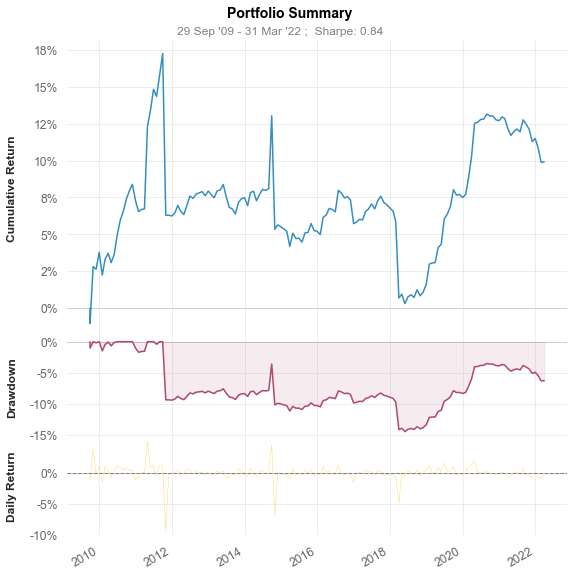

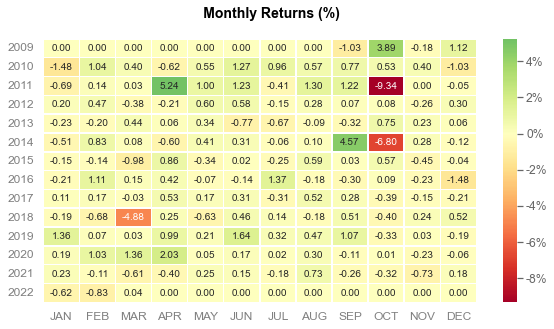

In [82]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

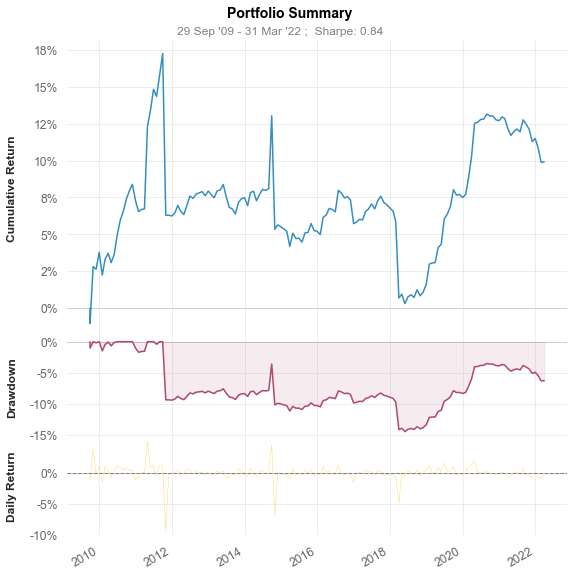

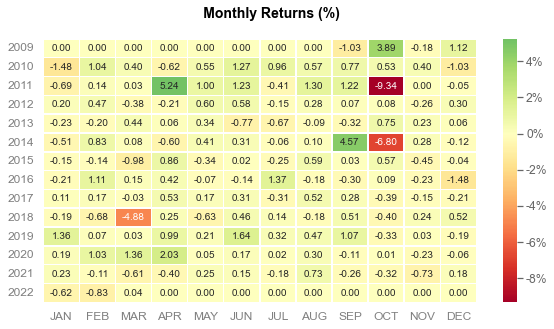

In [83]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2009-09-30  2009-09-30
End Period                 2022-03-31  2022-03-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          9.92%       185.66%
CAGR﹪                     0.76%       8.75%

Sharpe                     0.85        6.12
Smart Sharpe               0.74        5.37
Sortino                    1.07        11.03
Smart Sortino              0.94        9.68
Sortino/√2                 0.75        7.8
Smart Sortino/√2           0.66        6.84
Omega                      1.25        1.25

Max Drawdown               -14.45%     -6.86%
Longest DD Days            3804        489
Volatility (ann.)          21.39%      29.44%
R^2                        0.02        0.02
Calmar                     0.05        1.28
Skew                       -2.7        -0.28
Kurtosis                   22.41       1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2011-10-31,2018-05-31,2022-03-31,3804,-14.453592,-14.093623
2,2010-12-31,2011-01-31,2011-04-30,120,-1.710397,-1.572349
3,2010-01-31,2010-01-31,2010-06-30,150,-1.480993,-0.673444
4,2011-07-31,2011-07-31,2011-08-31,31,-0.412415,0.000000
5,2009-11-30,2009-11-30,2009-12-31,31,-0.182325,0.000000


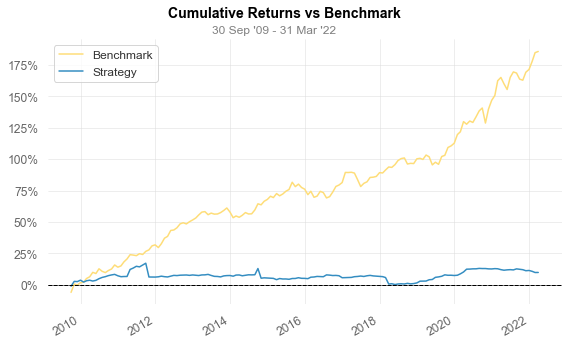

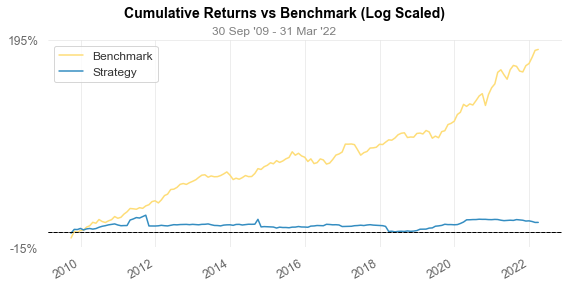

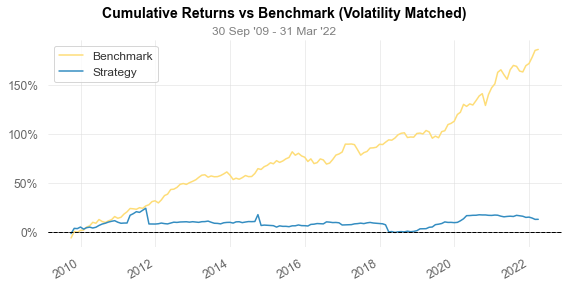

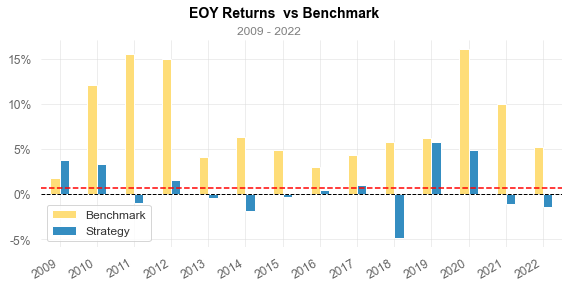

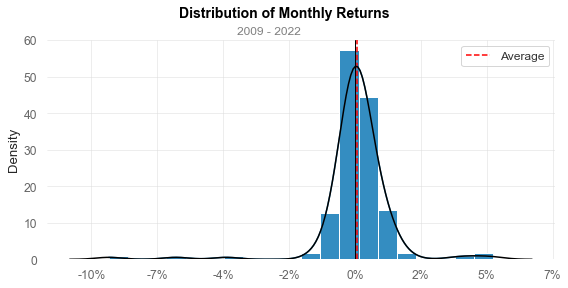

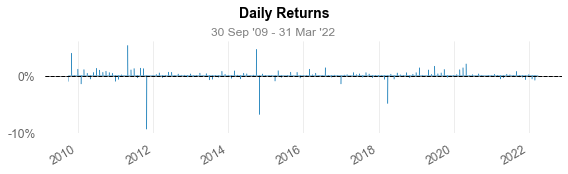

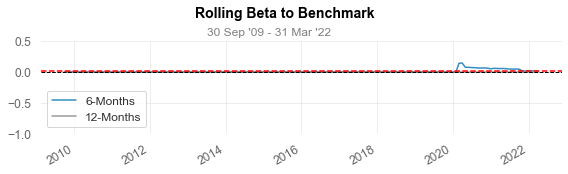

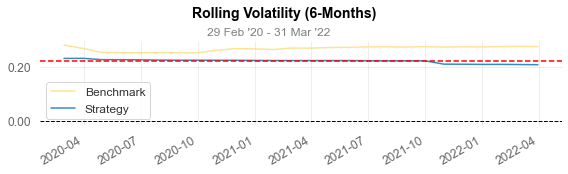

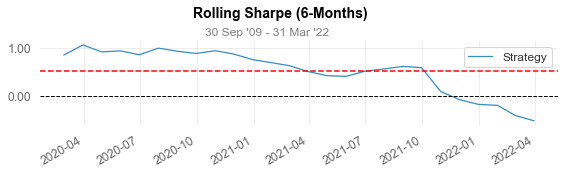

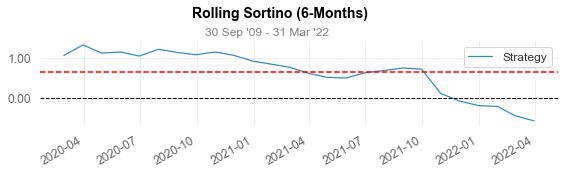

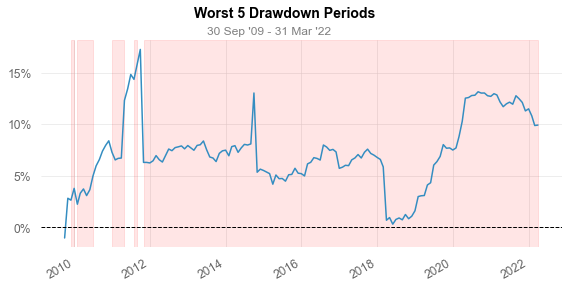

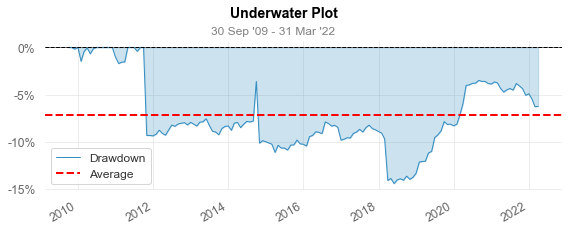

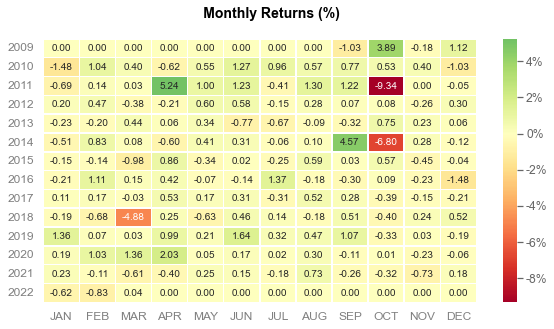

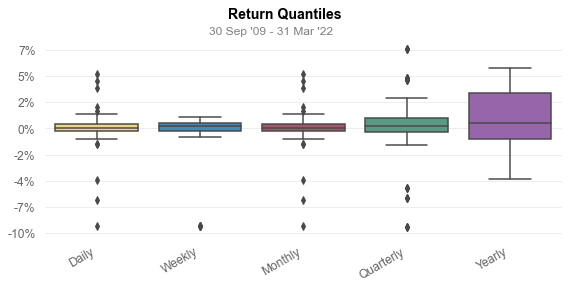

In [84]:
quantstats.reports.full(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'],)

In [90]:
canaria = yield_df[['IVV','VWO','BND']]
canaria.corr()

,IVV,VWO,BND
IVV,1.000000,0.826179,0.031949
VWO,0.826179,1.000000,0.118469
BND,0.031949,0.118469,1.000000


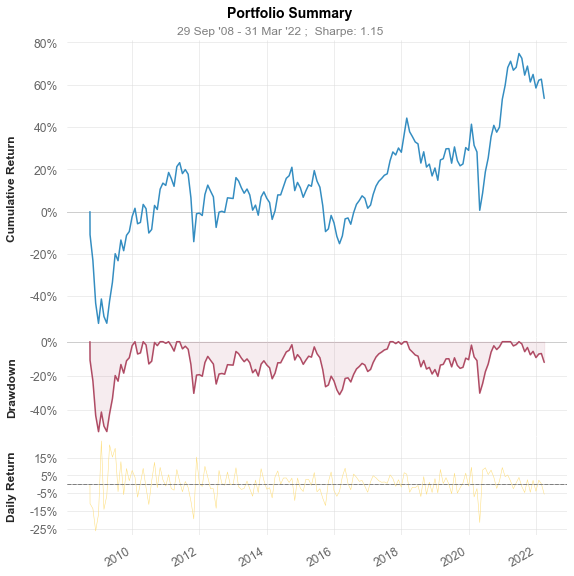

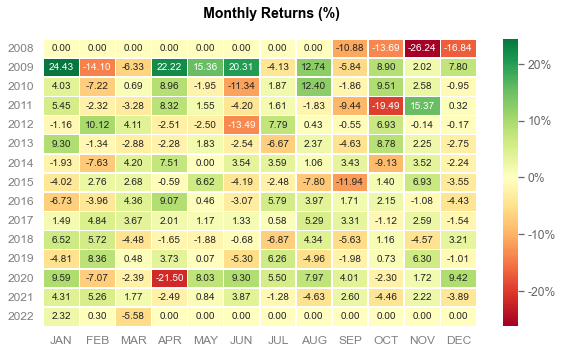

In [91]:
quantstats.reports.plots(returns = canaria.loc[ : , 'VWO'],benchmark = canaria.loc[ :, 'IVV'],mode='basic')

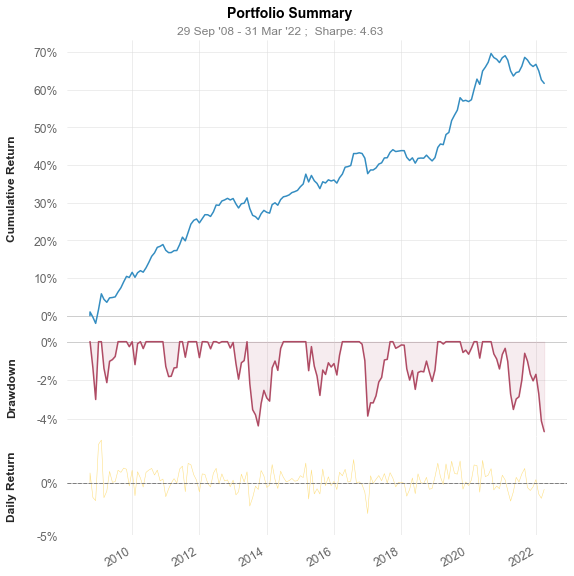

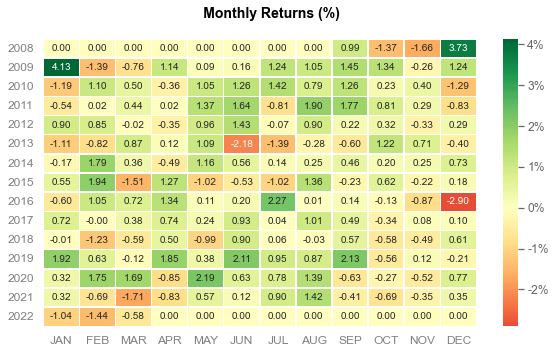

In [92]:
quantstats.reports.plots(returns = canaria.loc[ : , 'BND'],benchmark = canaria.loc[ :, 'IVV'],mode='basic')

## Why this strategy always escape from market
|Monthly Signal|Emerging|
|---|---|
|**Postive**|33|
|**Negative**|117|

## Canaria Assets underperformance cause severe underperformance relatively
#### Canaria option acts if any canaria condition satisfied.Underperformance of emerging market momentum score triggered canaria too often
#### This can cause further underperformance of emerging market relative to developed market. If any canaria condition triggers, the strategy escape from market, meaning that huge opportunity cost from rising developed market